# 21AG3AI05 DLFA ASSIGNMENT-2

# Task 1: Load the FER-2013 dataset

In [4]:
# Install all dependencies required for the Facial Expression Recognition CNN
!pip install torch torchvision
!pip install opencv-python
!pip install numpy pandas matplotlib seaborn
!pip install kagglehub



  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (767 kB)


Dataset downloaded to: /home/mahesh/.cache/kagglehub/datasets/ninamustwin/fer2013/versions/1
Attempting to load from torchvision...
Error loading from torchvision: train.csv not found in data/fer2013 or corrupted. You can download it from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge
Loading from CSV file instead...
CSV file loaded successfully. Total samples: 35887
Training samples: 28709
Test samples: 7178
Datasets created from CSV file successfully.
Emotion labels: {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
Training dataset size: 28709
Test dataset size: 7178
Sample image shape: torch.Size([1, 48, 48])
Sample label: 0 (Angry)


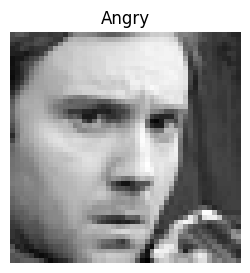

In [10]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt

# First, download the dataset using kagglehub if not already available
try:
    import kagglehub
    # Download the FER-2013 dataset
    path = kagglehub.dataset_download("ninamustwin/fer2013")
    print(f"Dataset downloaded to: {path}")
    csv_path = os.path.join(path, "fer2013.csv")
except:
    print("Unable to download using kagglehub. Please download the dataset manually.")
    # Default path if manually downloaded
    csv_path = 'fer2013.csv'

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Custom Dataset class for FER-2013
class FER2013Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Each row in the CSV file contains:
        # 'emotion' (label) and 'pixels' (space-separated pixel values)
        emotion = self.data.iloc[idx, 0]
        pixels = self.data.iloc[idx, 1].split()
        pixels = [int(pixel) for pixel in pixels]

        # Reshape pixels to 48x48 image
        image = np.array(pixels).reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, emotion

# Try to load from torchvision first (without 'download' parameter)
try:
    print("Attempting to load from torchvision...")
    train_dataset = torchvision.datasets.FER2013(root='./data', split='train', transform=transform)
    test_dataset = torchvision.datasets.FER2013(root='./data', split='test', transform=transform)
    print("Dataset loaded from torchvision successfully.")
except Exception as e:
    print(f"Error loading from torchvision: {e}")
    print("Loading from CSV file instead...")

    # Check if the CSV file exists
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"FER-2013 CSV file not found at {csv_path}. Please download it from Kaggle.")

    # Load the full dataset
    fer_data = pd.read_csv(csv_path)
    print(f"CSV file loaded successfully. Total samples: {len(fer_data)}")

    # Split into train and test based on 'Usage' column
    train_data = fer_data[fer_data['Usage'] == 'Training']
    test_data = fer_data[fer_data['Usage'].isin(['PublicTest', 'PrivateTest'])]

    print(f"Training samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")

    # Save the splits (optional)
    train_csv_path = os.path.join(os.path.dirname(csv_path), 'fer2013_train.csv')
    test_csv_path = os.path.join(os.path.dirname(csv_path), 'fer2013_test.csv')

    train_data.to_csv(train_csv_path, index=False)
    test_data.to_csv(test_csv_path, index=False)

    # Create dataset objects
    train_dataset = FER2013Dataset(csv_file=train_csv_path, transform=transform)
    test_dataset = FER2013Dataset(csv_file=test_csv_path, transform=transform)
    print("Datasets created from CSV file successfully.")

# Define emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
print("Emotion labels:", emotion_labels)

# Print dataset information
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Sample one image to verify loading
sample_idx = 0
sample_img, sample_label = train_dataset[sample_idx]
print(f"Sample image shape: {sample_img.shape}")
print(f"Sample label: {sample_label} ({emotion_labels[sample_label]})")

# Display the sample image
plt.figure(figsize=(3, 3))
img = sample_img.numpy().transpose((1, 2, 0))  # Convert from tensor to numpy
img = img * 0.5 + 0.5  # Unnormalize
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"{emotion_labels[sample_label]}")
plt.axis('off')
plt.show()


# Task 2: Divide the train split into training and validation

In [11]:
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the split ratio (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training subset size: 22967
Validation subset size: 5742
Test dataset size: 7178


# Task 3: Visualize the dataset

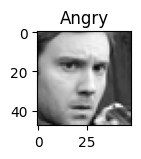

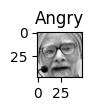

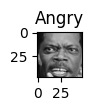

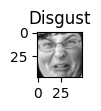

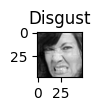

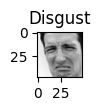

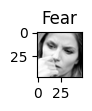

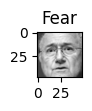

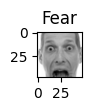

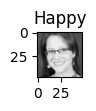

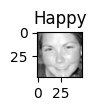

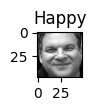

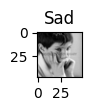

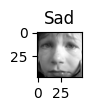

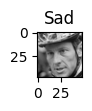

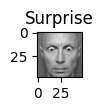

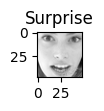

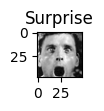

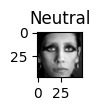

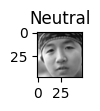

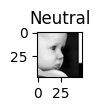

<Figure size 640x480 with 0 Axes>

In [12]:
# Function to show image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor to numpy
    # Un-normalize
    mean = np.array([0.5])
    std = np.array([0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Dictionary to collect samples by class
samples_by_class = {i: [] for i in range(7)}  # 7 emotions in FER-2013

# Iterate through dataset to collect samples for each class
for i, (image, label) in enumerate(train_dataset):
    if len(samples_by_class[label]) < 3:  # Collect 3 samples per class
        samples_by_class[label].append(image)

    # Check if we have collected enough samples
    if all(len(samples) >= 3 for samples in samples_by_class.values()):
        break

# Plotting
plt.figure(figsize=(15, 10))
for class_idx, samples in samples_by_class.items():
    for i, sample in enumerate(samples):
        plt.subplot(7, 3, class_idx * 3 + i + 1)
        imshow(sample, f"{emotion_labels[class_idx]}")

plt.tight_layout()
plt.show()


# Task 4: Design a custom CNN model

In [13]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomCNN, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual blocks
        self.res1 = ResidualBlock(32, 32)  # First residual connection
        self.res2 = ResidualBlock(32, 64, stride=2)  # Second residual connection with downsampling

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # 1x1 convolution for classification (replacing FC layer)
        self.conv_classifier = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        # Apply residual blocks
        x = self.res1(x)
        x = self.res2(x)

        # Global Average Pooling
        x = self.gap(x)

        # Apply 1x1 convolution for classification
        x = self.conv_classifier(x)

        # Squeeze the spatial dimensions
        x = x.view(x.size(0), -1)

        return x

# Create the model
model = CustomCNN()
print(model)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Summary of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {count_parameters(model)}")


CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (res2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut

# Task 5: Train the custom CNN model

Epoch: 1/25
**********
train Loss: 1.77469 Acc: 0.26708
val Loss: 1.77089 Acc: 0.27429

Epoch: 2/25
**********
train Loss: 1.69880 Acc: 0.31632
val Loss: 1.66365 Acc: 0.33542

Epoch: 3/25
**********
train Loss: 1.61188 Acc: 0.36792
val Loss: 1.92941 Acc: 0.25984

Epoch: 4/25
**********
train Loss: 1.52577 Acc: 0.41316
val Loss: 1.54069 Acc: 0.39011

Epoch: 5/25
**********
train Loss: 1.45860 Acc: 0.44359
val Loss: 1.79844 Acc: 0.33925

Epoch: 6/25
**********
train Loss: 1.40524 Acc: 0.46684
val Loss: 1.48011 Acc: 0.42668

Epoch: 7/25
**********
train Loss: 1.36274 Acc: 0.48448
val Loss: 1.65217 Acc: 0.39411

Epoch: 8/25
**********
train Loss: 1.31921 Acc: 0.50067
val Loss: 1.44801 Acc: 0.42807

Epoch: 9/25
**********
train Loss: 1.28476 Acc: 0.51461
val Loss: 1.32453 Acc: 0.49373

Epoch: 10/25
**********
train Loss: 1.25712 Acc: 0.52532
val Loss: 1.31289 Acc: 0.50157

Epoch: 11/25
**********
train Loss: 1.23034 Acc: 0.53625
val Loss: 1.62191 Acc: 0.38819

Epoch: 12/25
**********
train 

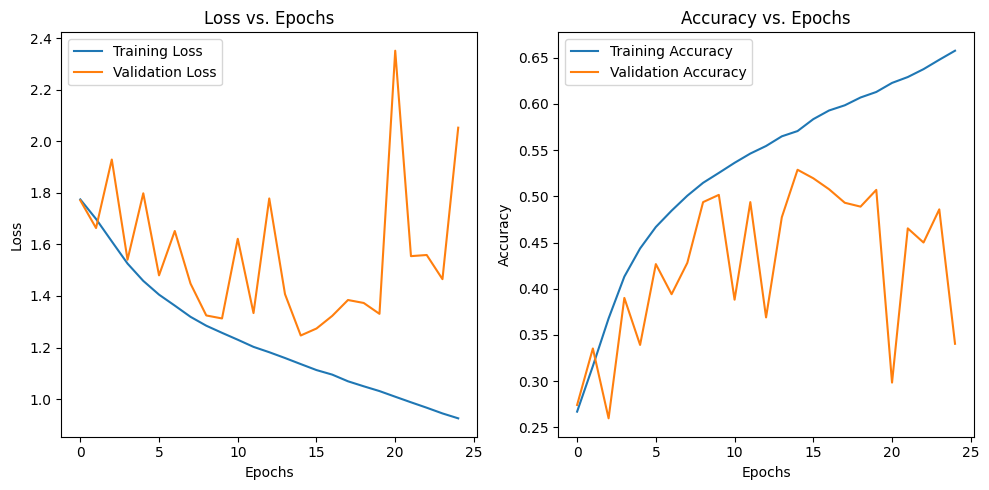

In [14]:
import torch.optim as optim
import time
import copy

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=(1e-3))

# Number of epochs
num_epochs = 25

# For tracking best model
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# For plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

since = time.time()

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print('*' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = train_loader
        else:
            model.eval()   # Set model to evaluate mode
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())

        print(f'{phase} Loss: {epoch_loss:.5f} Acc: {epoch_acc:.5f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Best val Acc: {best_acc:4f}')

# Load best model weights
model.load_state_dict(best_model_wts)

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.tight_layout()
plt.show()


# Task 6: Evaluate the trained model on the test set


/home/mahesh/SPAI_ons/understanding_cvai_ons/shashvat/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Test Accuracy: 0.5188
#Test Precision: 0.5265
#Test Recall: 0.5188


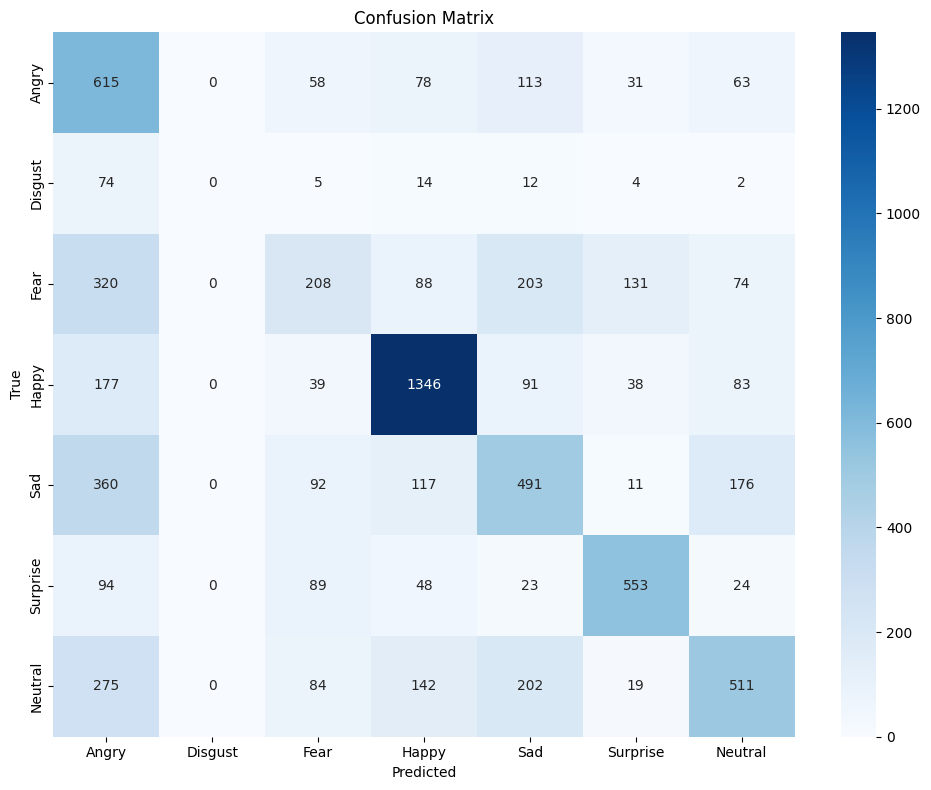

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, conf_matrix

# Evaluate the model on the test set
test_accuracy, test_precision, test_recall, test_conf_matrix = evaluate_model(model, test_loader)

print(f"#Test Accuracy: {test_accuracy:.4f}")
print(f"#Test Precision: {test_precision:.4f}")
print(f"#Test Recall: {test_recall:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(emotion_labels.values()),
            yticklabels=list(emotion_labels.values()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# Task 7: Generate Class Activation Maps (CAMs) using Grad-CAM


In [16]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-s1kd8a58
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-s1kd8a58
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 51967a7f23c48b9107e7bca1883a39a9d4c6342c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=43632 sha256=3f7390218d4692ab75b546c49ea4639a3c417dcc67b202622179bba5a9a6461c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfh5_1yr/wheels/69/29/f7/3abdb24031a22af044df15784c8a00f56b6e24f5924e33d0e8
Successfully built grad-cam


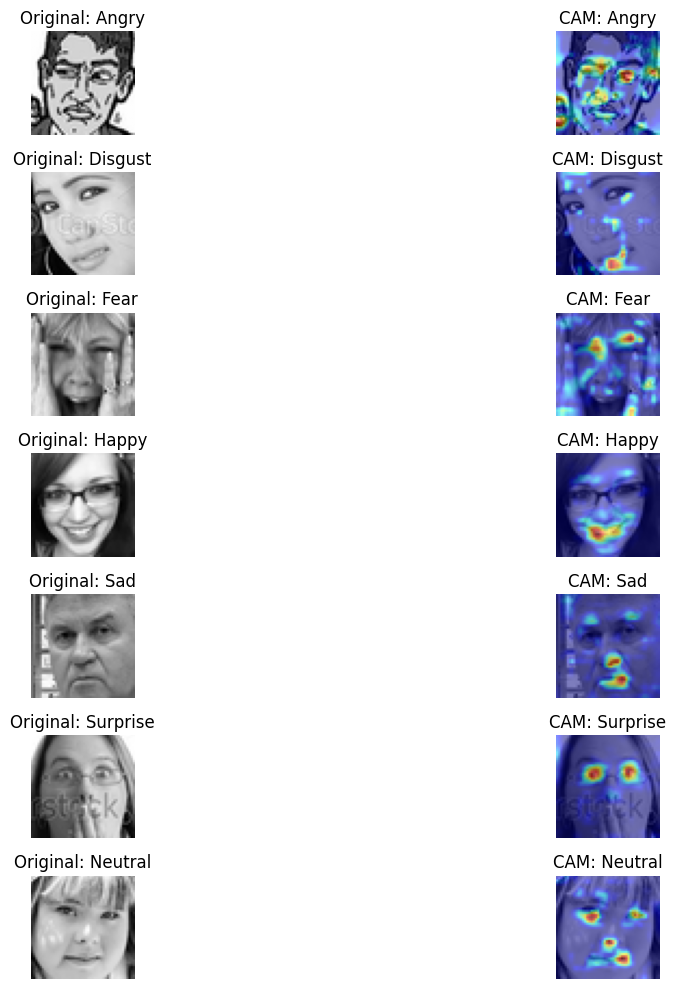

In [17]:
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the target layer for Grad-CAM
target_layer = [model.res2]  # Using the last residual block

# Initialize GradCAM
grad_cam = GradCAM(model=model, target_layers=target_layer)

# Get random samples from each class in the test set
samples_by_class = {i: [] for i in range(7)}
images_by_class = {i: [] for i in range(7)}
labels_by_class = {i: [] for i in range(7)}

# Collect samples from each class
for inputs, labels in test_loader:
    for i in range(len(labels)):
        label = labels[i].item()
        if len(samples_by_class[label]) < 1:  # Collect one sample per class
            samples_by_class[label].append(inputs[i])
            images_by_class[label].append(inputs[i].permute(1, 2, 0).cpu().numpy())
            labels_by_class[label].append(label)

    # Check if we have collected enough samples
    if all(len(samples) >= 1 for samples in samples_by_class.values()):
        break

# Function to generate and display CAM
def generate_cam(model, input_tensor, target_category, grad_cam):
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate CAM
    grayscale_cam = grad_cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    # Convert input tensor to numpy for visualization
    input_image = input_tensor.cpu().squeeze()

    # Check dimensions and handle accordingly
    if len(input_image.shape) == 3:
        input_image = input_image.permute(1, 2, 0).numpy()
    else:  # For 2D tensor (grayscale image)
        input_image = input_image.numpy()
        # Add channel dimension for compatibility with show_cam_on_image
        input_image = np.expand_dims(input_image, axis=2)

    # Normalize image for visualization
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())

    # Visualize CAM on image
    cam_image = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

    return cam_image


# Generate and display CAMs for each class
plt.figure(figsize=(15, 10))

for class_idx in range(7):
    if len(samples_by_class[class_idx]) > 0:
        sample = samples_by_class[class_idx][0]

        # Generate CAM
        cam_image = generate_cam(model, sample, class_idx, grad_cam)

        # Display original image
        plt.subplot(7, 2, 2 * class_idx + 1)
        plt.imshow(images_by_class[class_idx][0].squeeze(), cmap='gray')
        plt.title(f"Original: {emotion_labels[class_idx]}")
        plt.axis('off')

        # Display CAM
        plt.subplot(7, 2, 2 * class_idx + 2)
        plt.imshow(cam_image)
        plt.title(f"CAM: {emotion_labels[class_idx]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


# Task 8: Implement a targeted FGSM adversarial attack

Total test samples of class Sad: 1247
Correctly classified as Sad before attack: 491
Successfully attacked (now classified as Happy): 324
Attack success rate: 65.99%


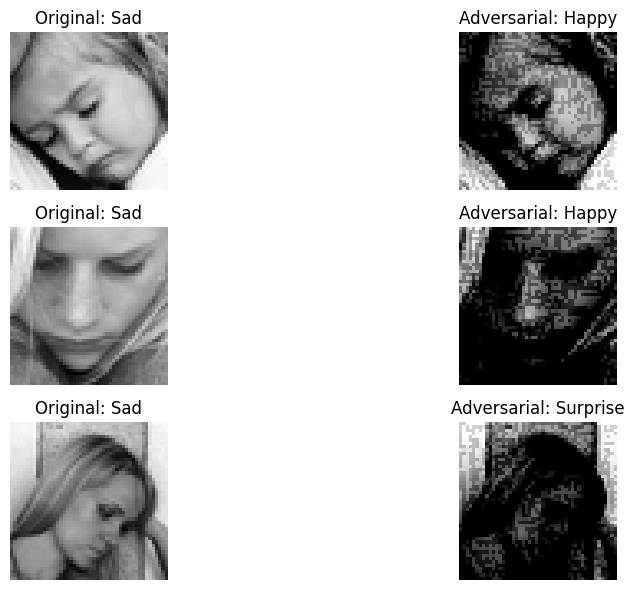

In [18]:
def fgsm_attack(image, epsilon, data_grad, target_class, model):
    """
    FGSM attack to move towards the target class
    For targeted attack, we move in the opposite direction of the sign of the gradient
    """
    # Get the sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    # For targeted attack, we subtract the gradient (move towards minimizing the loss for target class)
    perturbed_image = image - epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

def targeted_attack(model, device, test_loader, target_class=3, source_class=4, epsilon=0.1):
    """
    Perform targeted FGSM attack on images of source_class to be classified as target_class
    source_class: 4 (Sad)
    target_class: 3 (Happy)
    """
    model.eval()

    # Counters
    correct_before = 0
    successful_attacks = 0
    total_samples = 0

    # Loop over all examples in test set that are of the source class
    for data, target in test_loader:
        # Filter only source class images
        source_indices = [i for i, t in enumerate(target) if t.item() == source_class]
        if not source_indices:
            continue

        # Get the samples of the source class
        data_source = data[source_indices].to(device)
        target_source = target[source_indices].to(device)
        total_samples += len(data_source)

        # Forward pass without gradients first
        with torch.no_grad():
            output = model(data_source)
            init_pred = output.max(1, keepdim=True)[1]

        # Check if initially classified correctly as source class
        correct_mask = (init_pred.squeeze() == target_source)
        correct_before += correct_mask.sum().item()

        # If no samples were correctly classified, continue to the next batch
        if correct_mask.sum().item() == 0:
            continue

        # Filter only correctly classified samples
        indices = torch.nonzero(correct_mask).squeeze()

        # Fix: Handle case when only one sample is correct (gives 0-d tensor)
        if indices.dim() == 0:
            indices = indices.unsqueeze(0)  # Convert to 1D tensor

        # Detach to make it a leaf tensor before setting requires_grad
        data_source_correct = data_source[indices].clone().detach()
        data_source_correct.requires_grad = True

        # Create target class tensor for loss calculation
        target_class_tensor = torch.full((len(indices),), target_class,
                                       dtype=torch.long, device=device)

        # Calculate loss with respect to the target class
        output = model(data_source_correct)
        loss = criterion(output, target_class_tensor)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data_source_correct.grad

        # Call FGSM Attack
        with torch.no_grad():
            # Get the sign of the data gradient
            sign_data_grad = data_grad.sign()

            # Create the perturbed image (subtract for targeted attack)
            perturbed_data = data_source_correct - epsilon * sign_data_grad

            # Adding clipping to maintain valid image range
            perturbed_data = torch.clamp(perturbed_data, 0, 1)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check if the attack was successful (predicted as target class)
        final_pred = output.max(1, keepdim=True)[1]
        successful_attacks += (final_pred.squeeze() == target_class).sum().item()

    # Calculate final accuracy
    success_rate = successful_attacks / correct_before if correct_before > 0 else 0

    print(f"Total test samples of class {emotion_labels[source_class]}: {total_samples}")
    print(f"Correctly classified as {emotion_labels[source_class]} before attack: {correct_before}")
    print(f"Successfully attacked (now classified as {emotion_labels[target_class]}): {successful_attacks}")
    print(f"Attack success rate: {success_rate:.2%}")


    return success_rate



# Perform targeted attack from "Sad" (4) to "Happy" (3)
epsilon = 0.1
success_rate = targeted_attack(model, device, test_loader, target_class=3, source_class=4, epsilon=epsilon)

# Visualize examples of the attack
def visualize_adversarial_examples(model, device, test_loader, source_class=4, target_class=3, epsilon=0.1, num_examples=5):
    model.eval()

    orig_images = []
    adv_images = []
    orig_preds = []
    adv_preds = []

    # Set for storing example indices to avoid repetition
    examples_found = 0

    for data, target in test_loader:
        # Filter only source class images
        source_indices = [i for i, t in enumerate(target) if t.item() == source_class]
        if not source_indices:
            continue

        # Get the samples of the source class
        data_source = data[source_indices].to(device)
        target_source = target[source_indices].to(device)

        # Forward pass without gradients first
        with torch.no_grad():
            output = model(data_source)
            init_pred = output.max(1, keepdim=True)[1]

        # Check if initially classified correctly as source class
        correct_mask = (init_pred.squeeze() == target_source)

        # If no samples were correctly classified, continue to the next batch
        if correct_mask.sum().item() == 0:
            continue

        # Filter only correctly classified samples
        indices = torch.nonzero(correct_mask).squeeze()

        # Handle case when only one sample is correct (gives 0-d tensor)
        if indices.dim() == 0:
            indices = indices.unsqueeze(0)  # Convert to 1D tensor

        # Limit the number of examples
        num_samples = min(len(indices), num_examples - examples_found)
        if num_samples <= 0:
            continue

        indices = indices[:num_samples]

        # Create leaf tensors with requires_grad=True
        data_source_correct = data_source[indices].clone().detach()
        data_source_correct.requires_grad = True

        # Create target class tensor for loss calculation
        target_class_tensor = torch.full((len(indices),), target_class,
                                       dtype=torch.long, device=device)

        # Calculate loss with respect to the target class
        output = model(data_source_correct)
        loss = criterion(output, target_class_tensor)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients
        loss.backward()

        # Collect gradients
        data_grad = data_source_correct.grad
        if data_grad is None:
            print("Warning: gradients are None, skipping this batch")
            continue

        # Create adversarial examples
        with torch.no_grad():

            sign_data_grad = data_grad.sign()
            perturbed_data = data_source_correct - epsilon * sign_data_grad
            perturbed_data = torch.clamp(perturbed_data, 0, 1)
            output_orig = model(data_source_correct)
            pred_orig = output_orig.max(1, keepdim=True)[1]

            # Get adversarial predictions
            output_adv = model(perturbed_data)
            pred_adv = output_adv.max(1, keepdim=True)[1]

            # Store successful examples
            for i in range(len(indices)):
                orig_images.append(data_source_correct[i].cpu())
                adv_images.append(perturbed_data[i].cpu())
                orig_preds.append(pred_orig[i].item())
                adv_preds.append(pred_adv[i].item())

                examples_found += 1
                if examples_found >= num_examples:
                    break

        if examples_found >= num_examples:
            break

    if examples_found == 0:
        print("No examples found to visualize.")
        return

    # Convert to numpy for visualization
    orig_images = [img.permute(1, 2, 0).numpy() for img in orig_images]
    adv_images = [img.permute(1, 2, 0).numpy() for img in adv_images]

    # Normalize images to [0,1] for visualization
    orig_images = [(img - img.min()) / (img.max() - img.min()) if (img.max() - img.min()) > 0 else img for img in orig_images]
    adv_images = [(img - img.min()) / (img.max() - img.min()) if (img.max() - img.min()) > 0 else img for img in adv_images]

    # Plot the examples
    plt.figure(figsize=(12, examples_found * 2))

    for i in range(len(orig_images)):
        # Original image
        plt.subplot(examples_found, 2, 2*i + 1)
        plt.imshow(orig_images[i].squeeze(), cmap='gray')
        plt.title(f"Original: {emotion_labels[orig_preds[i]]}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(examples_found, 2, 2*i + 2)
        plt.imshow(adv_images[i].squeeze(), cmap='gray')
        plt.title(f"Adversarial: {emotion_labels[adv_preds[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize examples of the attack
visualize_adversarial_examples(model, device, test_loader, source_class=4, target_class=3, epsilon=epsilon, num_examples=3)
